In [1]:
from utility.clean_data_func import clean_and_filter_data
import re

def remove_special_characters(text):
    """Removes special characters from a text string."""
    pattern = r"[^\w\s]"  # Keep alphanumeric characters and whitespace
    return re.sub(pattern, "", text)


def lowercase(text):
    """Converts a text string to lowercase."""
    return text.lower()


# Clean data
print("Clean data")
df = clean_and_filter_data("./utility/azarbeijan-reviews.csv")
df["content"] = df["content"].apply(remove_special_characters)
df["content"] = df["content"].apply(lowercase)

Clean data
                                             content  score  upvotes
0                                          Çox qəşəy      5        0
1  Men niye nomre ile qeydiyatdan kece bilmirem.....      1        0
2  Salam. Mən yukluyə bilmirəm. Necə kömək edə bi...      5        0
3                                          cox gözəl      5        1
4  Xaiş edirem bu problemi hell edinde həftədə 2 ...      5        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127537 entries, 0 to 127536
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  127534 non-null  object
 1   score    127537 non-null  int64 
 2   upvotes  127537 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ MB
None
content    3
score      0
upvotes    0
dtype: int64


In [2]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Assuming 'df' contains your text data in a column named 'content'
sentences = [word_tokenize(text.lower()) for text in df['content']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, epochs=10)

[nltk_data] Downloading package punkt to /Users/hasaneke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import numpy as np

def sentence_vector(sentence, model):
    words = [word for word in sentence if word in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)

# Apply this function to each row in the DataFrame to create features
df['vector'] = df['content'].apply(lambda x: sentence_vector(word_tokenize(x.lower()), w2v_model))

In [4]:
labels = np.array([1 if score >= 4 else 0 for score in df['score']])

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Prepare data
features = np.stack(df['vector'].values)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Dense(64, activation='sigmoid', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


/Users/hasaneke/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.8034 - loss: 0.4909 - val_accuracy: 0.8142 - val_loss: 0.4355
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.8210 - loss: 0.4336 - val_accuracy: 0.8193 - val_loss: 0.4298
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.8191 - loss: 0.4287 - val_accuracy: 0.8207 - val_loss: 0.4269
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.8228 - loss: 0.4211 - val_accuracy: 0.8269 - val_loss: 0.4249
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.8207 - loss: 0.4288 - val_accuracy: 0.8258 - val_loss: 0.4230
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.8209 - loss: 0.4160 - val_accuracy: 0.8211 - val_loss: 0.4246
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.8254 - loss: 0.4114 - val_accuracy: 0.8258 - val_loss: 0.4216
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.8265 - loss: 0.4060 - val_accurac

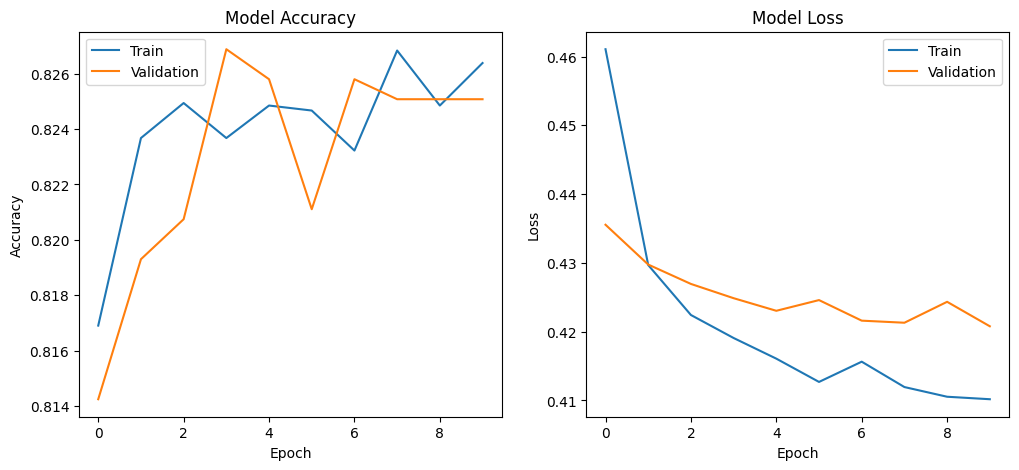

In [6]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()